In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import os

%matplotlib inline

path = '/'.join(os.getcwd().split('/')[:-1])
print(path)

tci = pd.read_csv(path+'/data/model_data/tci_1_0.csv', parse_dates=['Date'])
cols = ['parcel','Date','vacant']
tci = tci[cols]
ppns = set(tci['parcel'])
dates = dict(zip(tci.parcel, tci.Date))

print(tci.shape)

/Volumes/Dropbox/largetransfer/luc/carter
(113132, 3)


//anaconda/envs/data_sci/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Violations

In [254]:
vs = pd.read_csv(path+'/data/clean_data/violations.csv', parse_dates = [1,4])
vs = vs.loc[vs.apply(lambda x: x.v_file_date < dates[x.parcel], axis=1)]

In [255]:
vs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166685 entries, 0 to 170837
Data columns (total 18 columns):
VIN                     166685 non-null object
v_file_date             166685 non-null datetime64[ns]
v_wf_task               166685 non-null object
v_wf_task_status        164852 non-null object
v_wf_task_date          166685 non-null datetime64[ns]
v_type_of_violation     160269 non-null object
parcel1                 122437 non-null object
parcel                  166685 non-null object
cond_gar                14894 non-null float64
cond                    40680 non-null float64
other                   26644 non-null float64
maint                   71716 non-null float64
fire                    4763 non-null float64
int_ext                 1540 non-null float64
vin_id                  123728 non-null object
violation_issue_date    123728 non-null object
vn_created              123728 non-null float64
vn_source               123728 non-null float64
dtypes: datetime64[ns](2), 

### Violation Task

In [256]:
dt.timedelta(days=365*2)

datetime.timedelta(730)

In [257]:
dates['005-19-056']-dt.timedelta(days=365*2)

Timestamp('2013-08-12 10:04:00')

In [258]:
# vs_task = pd.DataFrame(vs.groupby('v_wf_task').count()['VIN'])
# vs_task.columns = ['violations_tasks']
# vs_task[vs_task.violations_tasks > 1]

In [259]:
# for task in set(vs.v_wf_task):
#     tci = pd.merge(tci, vs.loc[vs.v_wf_task==task,['parcel','v_wf_task']].groupby('parcel').count(), how='left', left_on = 'ppn', right_index=True)
#     tci = tci.rename(columns={'v_wf_task': task.lower()+' count'})
#     tci[task.lower()+' count'] = tci[task.lower()+' count'].fillna(0)
# #     print task, len(a), sum(a.vacant)*1.0/len(a.vacant)

In [260]:
# def check_task(x):
#     if x in parcel_set:
#         return 1
#     else:
#         return 0
    
# for task in vs_task.index:
#     parcel_set = set(vs.loc[vs.v_wf_task==task,'parcel'])
#     tci['task_'+task[0:3].lower()] = tci['ppn'].apply(check_task)

### Violations count 

In [261]:
vs_copy = vs.groupby('VIN').last().reset_index()

vs_copy = vs_copy[['parcel','v_file_date']].groupby('parcel').count().reset_index()

vs_copy['vs_count'] = vs_copy.apply(lambda x: \
        len(vs[(vs.parcel == x.parcel) & (vs.v_file_date > dates[x.parcel]-pd.DateOffset(years=1))]), axis=1)

vs_copy = vs_copy.rename(columns={'vs_count':'v_total_1yr'})
vs_copy = vs_copy.set_index('parcel')

In [262]:
tci = pd.merge(tci, vs_copy[['v_total_1yr']], \
               how='left', left_on='parcel', right_index=True)
tci.loc[tci.v_total_1yr.isnull(), 'v_total_1yr'] = 0

In [263]:
vs_copy = vs.groupby('VIN').last().reset_index()

vs_copy = vs_copy[['parcel','v_file_date']].groupby('parcel').count().reset_index()

vs_copy['vs_count'] = vs_copy.apply(lambda x: \
        len(vs[(vs.parcel == x.parcel) & (vs.v_file_date > dates[x.parcel]-pd.DateOffset(years=2))]), axis=1)

vs_copy = vs_copy.rename(columns={'vs_count':'v_total_2yr'})
vs_copy = vs_copy.set_index('parcel')

In [264]:
tci = pd.merge(tci, vs_copy[['v_total_2yr']], \
               how='left', left_on='parcel', right_index=True)
tci.loc[tci.v_total_2yr.isnull(), 'v_total_2yr'] = 0

In [265]:
# vs_count = pd.DataFrame(vs[vs['v_file_date']>dt.datetime(2013,6,1)].groupby('VIN').last().groupby('parcel').count()['v_file_date'])
# vs_count = vs_count.rename(columns={'v_file_date':'violations_number_2_yr'})
# tci = pd.merge(tci, vs_count[['violations_number_2_yr']], \
#                how='left', left_on='ppn', right_index=True)
# tci.loc[tci.violations_number_2_yr.isnull(), 'violations_number_2_yr'] = 0

### Violation types

In [266]:
# def fun(x):
#     return (x.v_file_date < dates[x.parcel]) & (x.v_file_date > dates[x.parcel]-dt.timedelta(days=120))    

In [267]:
# vs_temp = vs.apply(fun, axis=1)

In [268]:
# violation_types = ['Condemnation - Main Structure','Fire Damage','Hazardous Conditions','Unauthorized/Illegal Use','Vacate']

In [269]:
# for vio in violation_types:
#     tem = vs.loc[(vs_temp) & (vs.v_type_of_violation==vio),['v_type_of_violation','parcel','VIN']].groupby('VIN').last().groupby('parcel').count()
#     tci = pd.merge(tci, tem, left_on='parcel', right_index=True, how='left')
#     tci = tci.rename(columns={'v_type_of_violation': 'v_'+vio.lower()[0:6]})
#     tci['v_'+vio.lower()[0:6]] = tci['v_'+vio.lower()[0:6]].fillna(0)

In [270]:
tci.columns

Index([u'parcel', u'Date', u'vacant', u'v_total_1yr', u'v_total_2yr'], dtype='object')

## Complaints

In [24]:
cp = pd.read_csv(path+'/data/clean_data/complaints.csv', parse_dates = [2],index_col=[0], dtype=str)
# cp = cp.loc[cp.apply(lambda x: x.c_file_date < dates[x.parcel], axis=1)]
cp = cp.sort_values('c_file_date')

In [272]:
# cp.info()

In [273]:
# cp.groupby('complaint_id').last().groupby(.agg(lambda x: len(set(x.parcel)))

In [274]:
# types = cp[cp.c_file_date > dt.datetime(2013,6,1)].groupby('complaint_id').last().groupby('c_type_of_complaint').count()['c_file_date'].sort_values(ascending=False).head(10)
# types

In [275]:
# def fun(x):
#     return (x.c_file_date < dates[x.parcel]) & (x.c_file_date > dates[x.parcel]-dt.timedelta(days=120))    
# cp_temp = cp.apply(fun, axis=1)

In [276]:
# types = ['Collapsing Structure','Complete interior/exterior','Fire Damage', \
#          'General Exterior Maintenance','No Permit', 'Vacant Distressed']

In [277]:
# for complaint in types:
#     tem = cp.loc[(cp_temp) & (cp.c_type_of_complaint==complaint),['c_type_of_complaint','parcel','complaint_id']].groupby('complaint_id').last().groupby('parcel').count()
#     tci = pd.merge(tci, tem, left_on='parcel', right_index=True, how='left')
#     tci = tci.rename(columns={'c_type_of_complaint': 'c_'+complaint.lower()[0:6]})
#     tci['c_'+complaint.lower()[0:6]] = tci['c_'+complaint.lower()[0:6]].fillna(0)

### Complaint type

In [5]:
cp = cp.loc[cp.apply(lambda x: x.c_file_date < dates[x.parcel], axis=1)]

In [6]:
cp_copy = cp[cp.c_type_of_complaint=='O.V.V.'].groupby('complaint_id').last().reset_index()
# cp_copy2 = cp_copy[['parcel','c_file_date']].groupby('parcel').last().reset_index()

In [280]:
# cp_copy2 = cp_copy

# cp_copy2['c_ovv_2yr'] = cp_copy2.apply(lambda x: \
#         len(cp[(cp.parcel == x.parcel) & (cp.c_file_date > dates[x.parcel]-pd.DateOffset(years=2))]), axis=1)

# cp_copy2 = cp_copy2.set_index('parcel')

# tci = pd.merge(tci, cp_copy2[['c_ovv_2yr']], \
#                how='left', left_on='parcel', right_index=True)
# tci.loc[tci.c_ovv_2yr.isnull(), 'c_ovv_2yr'] = 0

In [281]:
# cp_copy2 = cp_copy

# cp_copy2['c_ovv_1yr'] = cp_copy2.apply(lambda x: \
#         len(cp[(cp.parcel == x.parcel) & (cp.c_file_date > dates[x.parcel]-pd.DateOffset(years=1))]), axis=1)

# cp_copy2 = cp_copy2.set_index('parcel')

# tci = pd.merge(tci, cp_copy2[['c_ovv_1yr']], \
#                how='left', left_on='parcel', right_index=True)
# tci.loc[tci.c_ovv_1yr.isnull(), 'c_ovv_1yr'] = 0

In [282]:
# cp_copy2 = cp_copy

# cp_copy2['c_ovv_3mo'] = cp_copy2.apply(lambda x: \
#         len(cp[(cp.parcel == x.parcel) & (cp.c_file_date > dates[x.parcel]-pd.DateOffset(months=3))]), axis=1)

# cp_copy2 = cp_copy2.set_index('parcel')

# tci = pd.merge(tci, cp_copy2[['c_ovv_3mo']], \
#                how='left', left_on='parcel', right_index=True)
# tci.loc[tci.c_ovv_3mo.isnull(), 'c_ovv_3mo'] = 0

In [12]:
min(tci.days_since_ovv_board_up)

3440

(array([  3.06000000e+02,   2.96000000e+02,   3.41000000e+02,
          3.23000000e+02,   1.56000000e+02,   4.30000000e+01,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.11665000e+05]),
 array([    0. ,   359.3,   718.6,  1077.9,  1437.2,  1796.5,  2155.8,
         2515.1,  2874.4,  3233.7,  3593. ]),
 <a list of 10 Patch objects>)

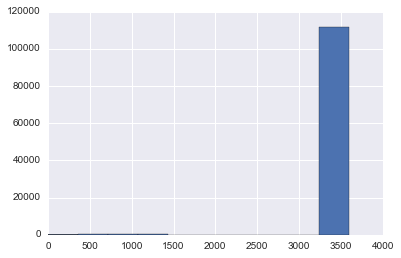

In [31]:
plt.hist(tci.days_since_ovv_board_up)

In [41]:
tci.loc[tci.parcel.isin(cp.loc[(cp.c_wf_task_status=='Closed-Board Up Requested')['parcel'])],
               .groupby('parcel')\
               .last()\
                    ,how='left', left_on='parcel', right_index=True)
tci = tci.rename(columns = {'c_file_date':'days_since_ovv_board_up'})
tci.loc[tci.days_since_ovv_board_up.isnull(),'days_since_ovv_board_up'] = dt.datetime(2006,1,1)
tci['days_since_ovv_board_up'] = tci.apply(lambda x: (x.Date-x.days_since_ovv_board_up).days, axis=1)

Timestamp('2005-10-28 00:00:00')

In [29]:
tci = pd.merge(tci, cp_copy.loc[(cp_copy.c_wf_task_status=='Closed-Board Up Requested'),['c_file_date','parcel']]\
               .groupby('parcel')\
               .last()\
                    ,how='left', left_on='parcel', right_index=True)
tci = tci.rename(columns = {'c_file_date':'days_since_ovv_board_up'})
tci.loc[tci.days_since_ovv_board_up.isnull(),'days_since_ovv_board_up'] = dt.datetime(2006,1,1)
tci['days_since_ovv_board_up'] = tci.apply(lambda x: (x.Date-x.days_since_ovv_board_up).days, axis=1)

In [ ]:
tci = pd.merge(tci, cp_copy.loc[(cp_copy.c_file_date > dt.datetime(2006,1,1))\
                                &(cp_copy.c_wf_task_status=='Closed-Board Up Requested'),['c_file_date','parcel']]\
               .groupby('parcel')\
               .last()\
                    ,how='left', left_on='parcel', right_index=True)
tci = tci.rename(columns = {'c_file_date':'days_since_ovv_board_up'})
tci.loc[tci.days_since_ovv_board_up.isnull(),'days_since_ovv_board_up'] = dt.datetime(2006,1,1)
tci['days_since_ovv_board_up'] = tci.apply(lambda x: (x.Date-x.days_since_ovv_board_up).days, axis=1)

tci = pd.merge(tci, cp_copy.loc[(cp_copy.c_file_date > dt.datetime(2006,1,1))\
                                &(cp_copy.c_wf_task_status=='Closed-Board Up Requested'),['c_file_date','parcel']]\
               .groupby('parcel')\
               .agg(lambda x: len(x)\
                    /((dates[x.parcel.iloc[0]] - dt.datetime(2006,1,1)).days/365.0))\
                    ,how='left', left_on='parcel', right_index=True)
tci = tci.rename(columns = {'c_file_date':'c_ovv_board_num'})
tci.loc[tci.c_ovv_board_num.isnull(),'c_ovv_board_num'] = 0



In [9]:
sum(tci.c_ovv_board_num)

0.0

In [285]:
tci = pd.merge(tci, cp_copy.loc[cp_copy.c_file_date > dt.datetime(2006,1,1),['c_file_date','parcel']]\
               .groupby('parcel')\
               .last()\
                    ,how='left', left_on='parcel', right_index=True)
tci = tci.rename(columns = {'c_file_date':'days_since_ovv'})
tci.loc[tci.days_since_ovv.isnull(),'days_since_ovv'] = dt.datetime(2006,1,1)
tci['days_since_ovv'] = tci.apply(lambda x: (x.Date-x.days_since_ovv).days, axis=1)

tci = pd.merge(tci, cp_copy.loc[cp_copy.c_file_date > dt.datetime(2006,1,1),['c_file_date','parcel']]\
               .groupby('parcel')\
               .agg(lambda x: len(x)\
                    /((dates[x.parcel.iloc[0]] - dt.datetime(2006,1,1)).days/365.0))\
                    ,how='left', left_on='parcel', right_index=True)
tci = tci.rename(columns = {'c_file_date':'c_ovv_num'})
tci.loc[tci.c_ovv_num.isnull(),'c_ovv_num'] = 0



In [286]:
# for complaint in ['O.V.V.']:
#     t = cp.loc[(cp.c_file_date > dt.datetime(2015,1,1)) & (cp.c_type_of_complaint==complaint),['c_type_of_complaint','parcel','complaint_id']] \
#             .groupby('complaint_id').last().groupby('parcel').count()[['c_type_of_complaint']]
#     t = t.rename(columns={'c_type_of_complaint': 'c_'+complaint+'_0yr'})
#     tem = pd.merge(tci, t, left_on='ppn', right_index=True, how='left')
#     tem['c_'+complaint+'_0yr'] = tem['c_'+complaint+'_0yr'].fillna(0)
#     print pd.crosstab(tem['c_'+complaint+'_0yr'], tem.vacant)

In [287]:
# for complaint in types.index:
#     t = cp.loc[(cp.c_file_date > dt.datetime(2014,6,1)) & (cp.c_type_of_complaint==complaint),['c_type_of_complaint','parcel','complaint_id']] \
#             .groupby('complaint_id').last().groupby('parcel').count()[['c_type_of_complaint']]
#     t = t.rename(columns={'c_type_of_complaint': 'c_'+complaint+'_1yr'})
#     tci = pd.merge(tci, t, left_on='ppn', right_index=True, how='left')
#     tci['c_'+complaint+'_1yr'] = tci['c_'+complaint+'_1yr'].fillna(0)
# #     print pd.crosstab(tem['c_'+complaint+'_1yr'], tem.vacant)

In [288]:
# for complaint in types.index:
#     t = cp.loc[(cp.c_file_date > dt.datetime(2013,6,1)) & (cp.c_type_of_complaint==complaint),['c_type_of_complaint','parcel','complaint_id']] \
#             .groupby('complaint_id').last().groupby('parcel').count()[['c_type_of_complaint']]
# #     t = cp.loc[cp.c_type_of_complaint==complaint,['c_type_of_complaint','parcel']].groupby('parcel').count()
#     t = t.rename(columns={'c_type_of_complaint': 'c_'+complaint+'_2yr'})
#     tci = pd.merge(tci, t, left_on='ppn', right_index=True, how='left')
#     tci['c_'+complaint+'_2yr'] = tci['c_'+complaint+'_2yr'].fillna(0)
# #     print pd.crosstab(tem['c_'+complaint+'_2yr'], tem.vacant)

### Complaint count (2 yrs)

In [289]:
# cp_count = pd.DataFrame(cp[(cp.c_file_date > dt.datetime(2013,6,1))].groupby('parcel').count()['complaint_id'])
# cp_count.columns = ['complaint_count_2yr']
# tci = pd.merge(tci, cp_count, \
#                how='left', left_on='ppn', right_index=True)
# tci.loc[tci.complaint_count_2yr.isnull(), 'complaint_count_2yr'] = 0

In [290]:
# sum(tci.loc[tci.complaint_count_2yr>5, 'vacant'])*1.0/len(tci.loc[tci.complaint_count_2yr>5, 'vacant'])

### Complaint count (1 yr)

In [291]:
# cp_count = pd.DataFrame(cp[cp.c_file_date>dt.datetime(2014, 6, 1)].groupby('parcel').count()['complaint_id'])
# cp_count.columns = ['complaint_count_1yr']
# tci = pd.merge(tci, cp_count, \
#                how='left', left_on='ppn', right_index=True)
# tci.loc[tci.complaint_count_1yr.isnull(), 'complaint_count_1yr'] = 0

In [292]:
# sum(tci.loc[tci.complaint_count_1yr>2, 'vacant'])*1.0/len(tci.loc[tci.complaint_count_1yr>2, 'vacant'])

### Complain count (6 months)

In [293]:
# cp_count = pd.DataFrame(cp[cp.c_file_date>dt.datetime(2015, 1, 1)].groupby('parcel').count()['complaint_id'])
# cp_count.columns = ['complaint_count_6_mon']
# tci = pd.merge(tci, cp_count, \
#                how='left', left_on='ppn', right_index=True)
# tci.loc[tci.complaint_count_6_mon.isnull(), 'complaint_count_6_mon'] = 0

In [294]:
# sum(tci.loc[tci.complaint_count_6_mon>0, 'vacant'])*1.0/len(tci.loc[tci.complaint_count_6_mon>0, 'vacant']) ,len(tci.loc[tci.complaint_count_6_mon>0, 'vacant'])

In [317]:
tci.to_csv(path+'/data/model_data/tci_2_2.csv', index=False)

In [315]:
tci.shape

(113132, 9)

In [316]:
tci.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113132 entries, 0 to 113131
Data columns (total 9 columns):
parcel                     113132 non-null object
Date                       113132 non-null datetime64[ns]
vacant                     113132 non-null int64
v_total_1yr                113132 non-null float64
v_total_2yr                113132 non-null float64
days_since_ovv             113132 non-null int64
c_ovv_num                  113132 non-null float64
days_since_ovv_board_up    113132 non-null int64
c_ovv_board_num            113132 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 8.6+ MB


In [298]:
min(cp.c_file_date)

Timestamp('2005-10-28 00:00:00')

In [299]:
set(cp.c_wf_task)

{'Closure',
 'Complaint Acceptance',
 'Complaint Chief Inspec',
 'Complaint Chief Inspector',
 'Complaint Inspector',
 'Inspection'}

In [318]:
len(tci[tci.parcel.isin(cp[(cp.c_wf_task_status=='Closed-Board Up Requested')].parcel)].vacant)

6107

In [319]:
len(tci[tci.parcel.isin(cp[(cp.c_type_of_complaint=='O.V.V.')&(cp.c_wf_task_status=='Closed-Board Up Requested')].parcel)].vacant)

6087

In [301]:
len(tci[tci.parcel.isin(cp[(cp.c_type_of_complaint=='O.V.V.') & (cp.c_file_date>dt.datetime(2014,1,1))].parcel)].vacant)

4146

In [302]:
sum(tci[tci.parcel.isin(cp[(cp.c_type_of_complaint=='O.V.V.')&(cp.c_wf_task_status=='Closed-Board Up Requested') & (cp.c_file_date>dt.datetime(2014,1,1))].parcel)].vacant)

2459